In [6]:
#neccesary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# read data into data_set
data_set = np.genfromtxt("hw05_data_set.csv", delimiter = ",")
# get X and Y values
X= data_set[:,0]
Y = data_set[:,1]

In [8]:
#Split into train and test sets
train_indices = np.arange(1,151)
test_indices = np.arange(151,273)
X_train =X[train_indices,]
y_train = Y[train_indices,]
X_test = X[test_indices,]
y_test = Y[test_indices,]


In [9]:
# get numbers of train and test samples
N_train = len(y_train)
N_test = len(y_test)


## Decision Tree

In [18]:
def RMSE(y_predicted,y_test):
    sum_squares = np.sum((y_test - y_predicted) **2)
    avg_sum_squares = sum_squares / y_test.shape
    return np.sqrt(avg_sum_squares)[0]

def plot_decision_tree(vals, y_predicted):
    f = plt.figure(figsize = (10, 6))
    #plot training and test sets
    plt.plot(X_train, y_train, "b.", markersize = 10, label = "Training Set")
    plt.plot(X_test, y_test, "r.", markersize = 10, label = "Test Set")
    plt.legend(loc = "upper left")
    plt.xlabel("Eruption Time (min)")
    plt.ylabel("RMSE")
    plt.plot(vals, y_predicted, color = "black")


#takes test set and returned parameters from learning decision tree
def decision_tree_predict(X_test,node_splits,node_means,is_terminal):
    N_test = X_test.shape[0]
    y_predicted = np.repeat(0,N_test)
    for i in range(N_test):
        index = 1
        while True:
            if is_terminal[index] == True:
                y_predicted[i] = node_means[index]
                break
            else:
                if X_test[i] > node_splits[index]:
                    index = index * 2
                else:
                    index = index * 2 + 1
    return y_predicted

#takes a X and corresponding y set learns a decision tree applying pruning with P
def decision_tree_calculate(X, y, P):
    
    # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_features = {}
    node_splits = {}
    node_means = {}

    # put all training instances into the root node
    N = len(y)
    node_indices[1] = np.array(range(N))
    is_terminal[1] = False
    need_split[1] = True
    # learning algorithm
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items() if value == True]
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
            
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_means[split_node] = np.mean(y[data_indices])

            #Pruning with P if so then it is terminal
            if(data_indices.size <= P):
                is_terminal[split_node] = True
    
            else:
                is_terminal[split_node] = False
                unique_values = np.sort(np.unique(X[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                for s in range(len(split_positions)):
                    left_indices = data_indices[X[data_indices] > split_positions[s]]
                    right_indices = data_indices[X[data_indices] <= split_positions[s]]
                    if (left_indices.size != 0):
                        split_scores[s] +=np.sum((y[left_indices] - np.mean(y[left_indices])) ** 2)
                    if (right_indices.size != 0):   
                        split_scores[s] +=  np.sum((y[right_indices] - np.mean(y[right_indices])) ** 2)
                    split_scores[s] /= left_indices.size+right_indices.size
                    
                best_score = np.min(split_scores)
                best_split = split_positions[np.argmin(split_scores)]
                # decide where to split on which feature 
                node_splits[split_node] = best_split

                # create left node using the selected split
                left_indices = data_indices[X[data_indices] > best_split]
                right_indices = data_indices[X[data_indices] <= best_split]
                node_indices[2 * split_node] = left_indices
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True
                node_indices[2 * split_node + 1] = right_indices
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True

    return node_splits,node_means,is_terminal



RMSE on train set is  4.550457852421739  when P is  25
RMSE on test set is  6.437594500340921  when P is  25


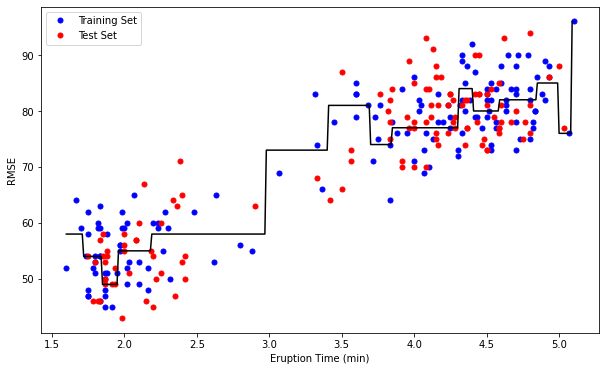

In [19]:
P = 25
node_splits,node_means,is_terminal = decision_tree_calculate(X_train,y_train,P)
y_training_predicted = decision_tree_predict(X_train,node_splits,node_means,is_terminal)
rmse = RMSE(y_training_predicted, y_train)
print("RMSE on train set is ", rmse, " when P is ", P)
y_predicted = decision_tree_predict(X_test, node_splits,node_means,is_terminal)
rmse = RMSE(y_predicted, y_test)
print("RMSE on test set is ", rmse, " when P is ", P)

vals = np.arange(min(X_train), max(X_train),0.01)
y_predicted_plot = decision_tree_predict(vals, node_splits,node_means,is_terminal)
plot_decision_tree(vals, y_predicted_plot)

    

In [14]:
pruning_parameters = np.arange(5,55,5)
rmse_train = []
rmse_test =  []
for P in pruning_parameters:
    node_splits,node_means,is_terminal = decision_tree_calculate(X_train,y_train,P)
    y_training_predicted = decision_tree_predict(X_train,node_splits,node_means,is_terminal)
    rmse = RMSE(y_training_predicted, y_train)
    rmse_train.append(rmse)
    y_predicted = decision_tree_predict(X_test, node_splits,node_means,is_terminal)
    rmse = RMSE(y_predicted, y_test)
    rmse_test.append(rmse)

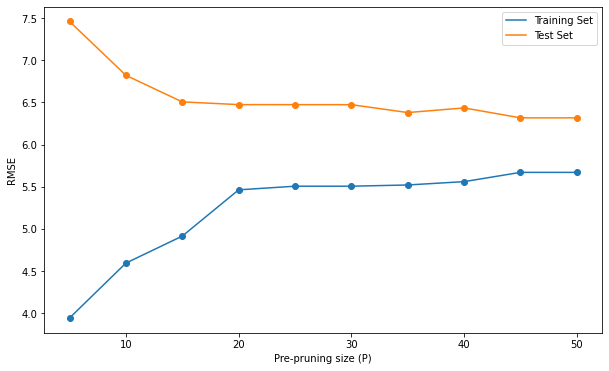

In [15]:
f = plt.figure(figsize = (10, 6))
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.scatter(pruning_parameters,rmse_train)
plt.plot(pruning_parameters,rmse_train,label = "Training Set")
plt.scatter(pruning_parameters,rmse_test)
plt.plot(pruning_parameters,rmse_test,label = "Test Set")
plt.legend(loc = "upper right")
plt.show()   
